In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
%matplotlib inline

# Objectives:

We want to look at bandits where the rewards are only 1 or 0 (Bernouilli).

There is one method (Bayesian) that we did not see during the course.
Some explanations there:
https://towardsdatascience.com/thompson-sampling-fc28817eacb8


1) COMPLETE the code where it says "COMPLETE".

2) Do simulations for a bandit with 2 arms P = [0.4, 0.8] for each of the mentionned decision rule and plot the corresponding  mean reward; the mean cumulative reward and the percentage of times the best arm was elected as time goes by. Interpret. 

3) Do simulations with a bandit with 10 arms (P = [0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2]). Plot the corresponding  mean reward; the mean cumulative reward and the percentage of times the best arm was elected as time goes by. Interpret.  
Play with the c parameter in UCB.

4) Study the dependence of the hyperparameter epsilon in the decision rule epsilon-greedy.

5) What are your conclusions in terms of methods? Give some intution.



In [2]:
class BernoulliBanditEnv(object): 
    # Class that defines the environment with reward 0 and 1 with probability p.

    def __init__(self, num_arms=10, p=None):
        self.num_arms = num_arms
        self.actions = np.arange(num_arms)     # define set of actions

        if len(p)==1:
            self.p = np.random.beta(0.5, 0.5, size=num_arms)
        elif len(p) == num_arms:
            self.p = p
        else:
            raise Exception('Number of probabilities ({}) does not correspond to number of arms ({}).'.format(len(q), num_arms))
        self.best_action = np.argmax(self.p)   # Best action given env

    def reward(self, action):
        return np.random.binomial(1, p=self.p[action])


In [24]:
class Agent(object):
    # Class which defines the agent. Each agent has a decision rule and a learning rule.
    
    def __init__(self, learning_rule, decision_rule, param=None):
        self.decision_rule = decision_rule
        self.learning_rule = learning_rule
        self.epsilon = 0
        self.UCB_param = 0

        if decision_rule == "epsilon-greedy":
            self.epsilon = param["epsilon"]
        
        if decision_rule == "UCB":
            self.UCB_param = param["UCB_param"]
    
    def environment(self, env, init_q):
        # initialize environment
        self.env = env                                  
        self.k = env.num_arms                           
        self.actions = np.arange(self.k)                
        self.act_count = np.zeros(self.k) #+10**(-10)               
        self.iteration = 0     
        if self.learning_rule == "BayesianBetaPrior":
            #self.alpha = np.random.uniform(size=self.k)
            #self.beta = np.random.uniform(size=self.k)
            self.alpha = np.ones(self.k)
            self.beta = np.ones(self.k)
        if len(init_q) == self.k:
            self.q_estimate = init_q
        else:
            raise Exception('Number of initial values ({}) does not correspond to number of arms ({}).'.format(len(init_q), self.k))

    def learn(self, a, r):
        # given action and reward, update value function.
        if self.learning_rule == "averaging":
            self.q_estimate[a] += 1/self.act_count[a] * (r - self.q_estimate[a])
            
        if self.learning_rule == "BayesianBetaPrior":
            self.alpha[a] += r
            self.beta[a] += 1 - r 
            
    def act(self):
        # action.
        self.iteration += 1 
        if self.decision_rule == "greedy":
            selected_action = np.argmax(self.q_estimate)
            pass

        if self.decision_rule == "epsilon-greedy":
            p = random.random()
            if (p<self.epsilon) : 
              #choose an arm at random
              nb_action=len(self.q_estimate)
              selected_action=np.random.random_integers(nb_action)-1
            else:
              selected_action = np.argmax(self.q_estimate)
            pass
        
        if self.decision_rule == "UCB":
            newT = (2*math.log(self.iteration))*(1/self.act_count)
            epsat = self.UCB_param*np.sqrt(newT)
            selected_action = np.argmax(self.q_estimate + epsat)
            pass

        if self.decision_rule == "Thompson":
            selected_action=np.argmax(np.random.beta(self.alpha,self.beta))
            pass
        self.act_count[selected_action] += 1
        return selected_action

In [4]:
def simulateBandits(agents, narms, initp=None, initq=None, repetitions=1000, N=100):
    # function that simulates the agents behaviour
    # agents is a list of agents.
    
    rewards = np.zeros((len(agents), repetitions, N))
    bestarm = np.zeros((len(agents), repetitions, N))
    for i, agent in enumerate(agents):
        for j in np.arange(repetitions):
            environment = BernoulliBanditEnv(num_arms=narms, p=initp)
            agent.environment(environment, initq if not(initq == None) else np.zeros(narms))
            for n in np.arange(N):
                a = agent.act()
                r = environment.reward(a)
                agent.learn(a, r)
                rewards[i, j, n] = r
                bestarm[i, j, n] = 1 if a == environment.best_action else 0
    
    return np.squeeze(np.mean(rewards, axis=1)), np.squeeze(np.mean(bestarm, axis=1))

In [ ]:
def plot_results(agents, actions, rewards):
  A,N = actions.shape
  x = np.arange(N)
  fig, axs = plt.subplots(A,2, figsize=(30,10))
  for i in range(A):
    cumu_rewards=[rewards[i][0]]
    for j in range (1,len(list(rewards[i]))):
      cumu_rewards.append(cumu_rewards[j-1]+rewards[i][j])
      
    axs[i][0].plot(x,rewards[i], label='rewards')
    axs[i][0].plot(x, actions[i], label='percentage of best arm choosen')
    axs[i][0].set_title('Agent n°' + str(i))
    axs[i][0].set_ylim([0,1])
    axs[i][1].set_title('Agent n°' + str(i))
    axs[i][1].plot(x, cumu_rewards, label='cumulative reward : '+ str(cumu_rewards[-1]))
    axs[i][0].legend(loc='lower right')
    axs[i][1].legend(loc='lower right')


In [36]:
param1 = {"epsilon":0.1,"UCB_param":0.1}
param2 = {"epsilon":0.2,"UCB_param":0.3}
param3 = {"epsilon":0.5,"UCB_param":0.1}
param4 = {"epsilon":1,"UCB_param":0.1} # All the choices are random

agents1 = [Agent("BayesianBetaPrior","greedy", param1), Agent("BayesianBetaPrior","epsilon-greedy",param3),Agent("BayesianBetaPrior","UCB",param3), Agent("BayesianBetaPrior","Thompson",param4)]
agents2 = [Agent("BayesianBetaPrior","greedy", param1), Agent("BayesianBetaPrior","epsilon-greedy",param2),Agent("BayesianBetaPrior","epsilon-greedy",param3), Agent("BayesianBetaPrior","epsilon-greedy",param4)]

res1=simulateBandits(agents1,narms=2,initp=[0.4,0.8],initq=[0.1,0.1])
res2=simulateBandits(agents1,narms=10,initp=[0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2],initq=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: This function is deprecated. Please call randint(1, 2 + 1) instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead


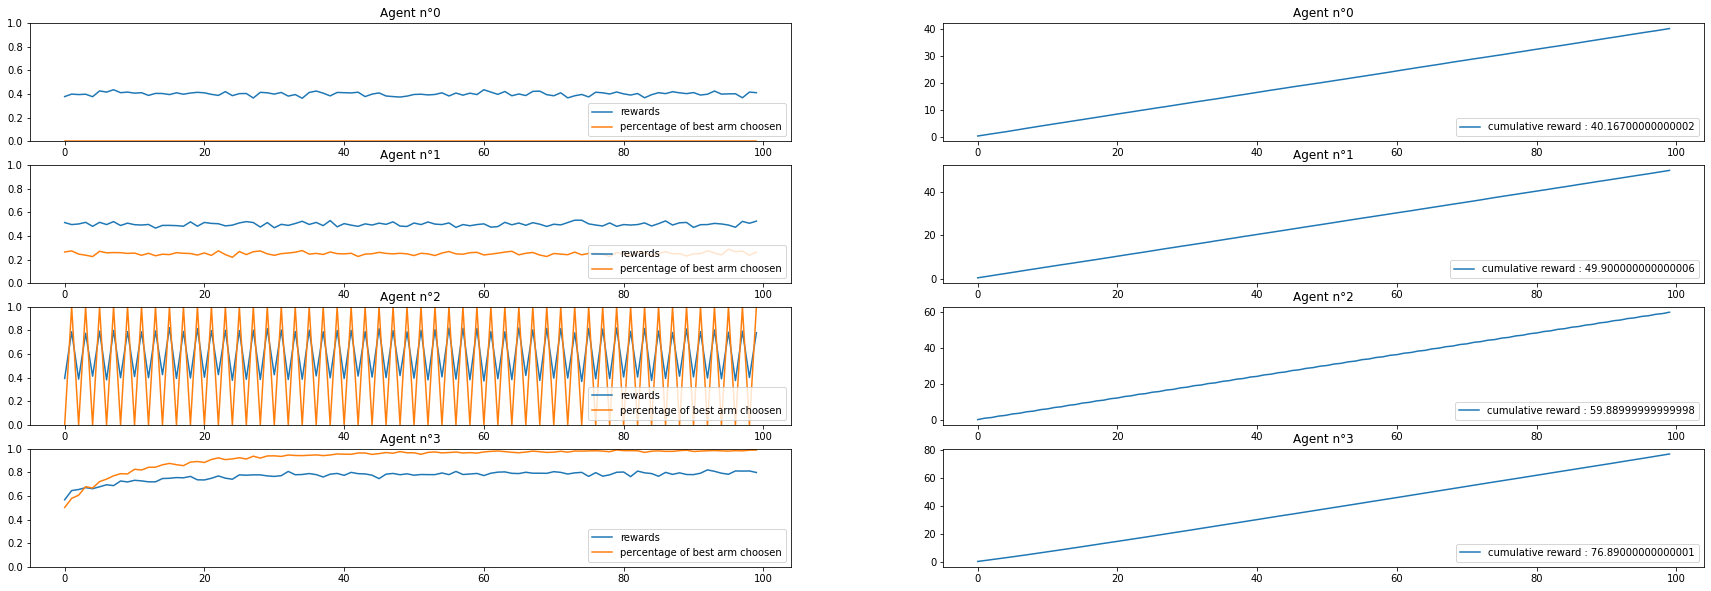

In [37]:
plot_results(agents1, res1[1], res1[0])

Interpretation : 

The greedy method strongly depends on the initialisation and is not really efficient. The UCB method allows us to visit almost equitably all the arms. The most efficient seems to be the Thompson method ( it gives us the best cummulative rewards and visit almost always the best arm after reasonable number of period).

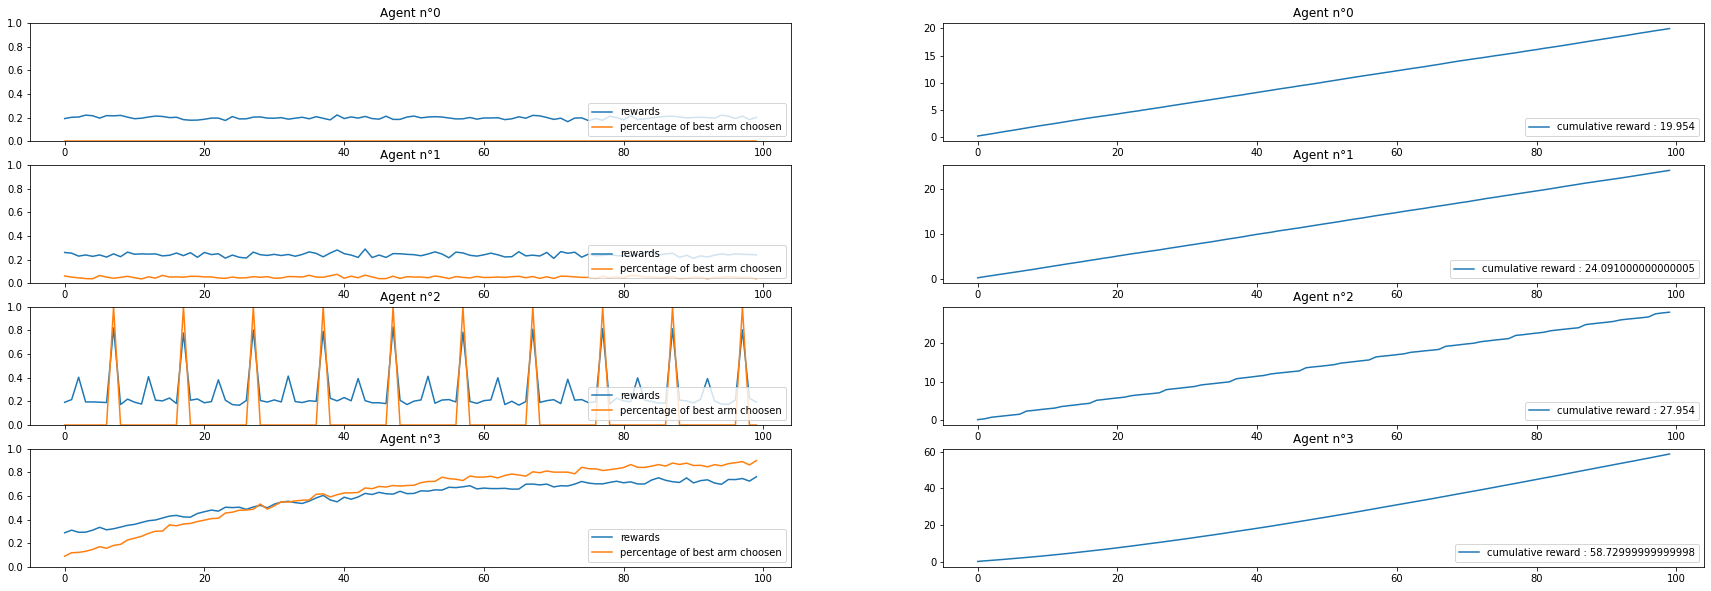

In [38]:
plot_results(agents1, res2[1], res2[0])

Here again, on a bigger experience (with more arms), the Thomson decision rule have better results.

In [39]:
param1 = {"epsilon":0.1,"UCB_param":0.1}
param2 = {"epsilon":0.2,"UCB_param":0.3}
param3 = {"epsilon":0.5,"UCB_param":0.1}
param4 = {"epsilon":1,"UCB_param":0.1} # All the choices are random

agents1 = [Agent("BayesianBetaPrior","greedy", param1), Agent("BayesianBetaPrior","epsilon-greedy",param3),Agent("BayesianBetaPrior","UCB",param3), Agent("BayesianBetaPrior","Thompson",param4)]
agents2 = [Agent("BayesianBetaPrior","greedy", param1), Agent("BayesianBetaPrior","epsilon-greedy",param2),Agent("BayesianBetaPrior","epsilon-greedy",param3), Agent("BayesianBetaPrior","epsilon-greedy",param4)]

res1=simulateBandits(agents2,narms=2,initp=[0.4,0.8],initq=[0.1,0.1])
res2=simulateBandits(agents2,narms=10,initp=[0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2],initq=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: This function is deprecated. Please call randint(1, 2 + 1) instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead


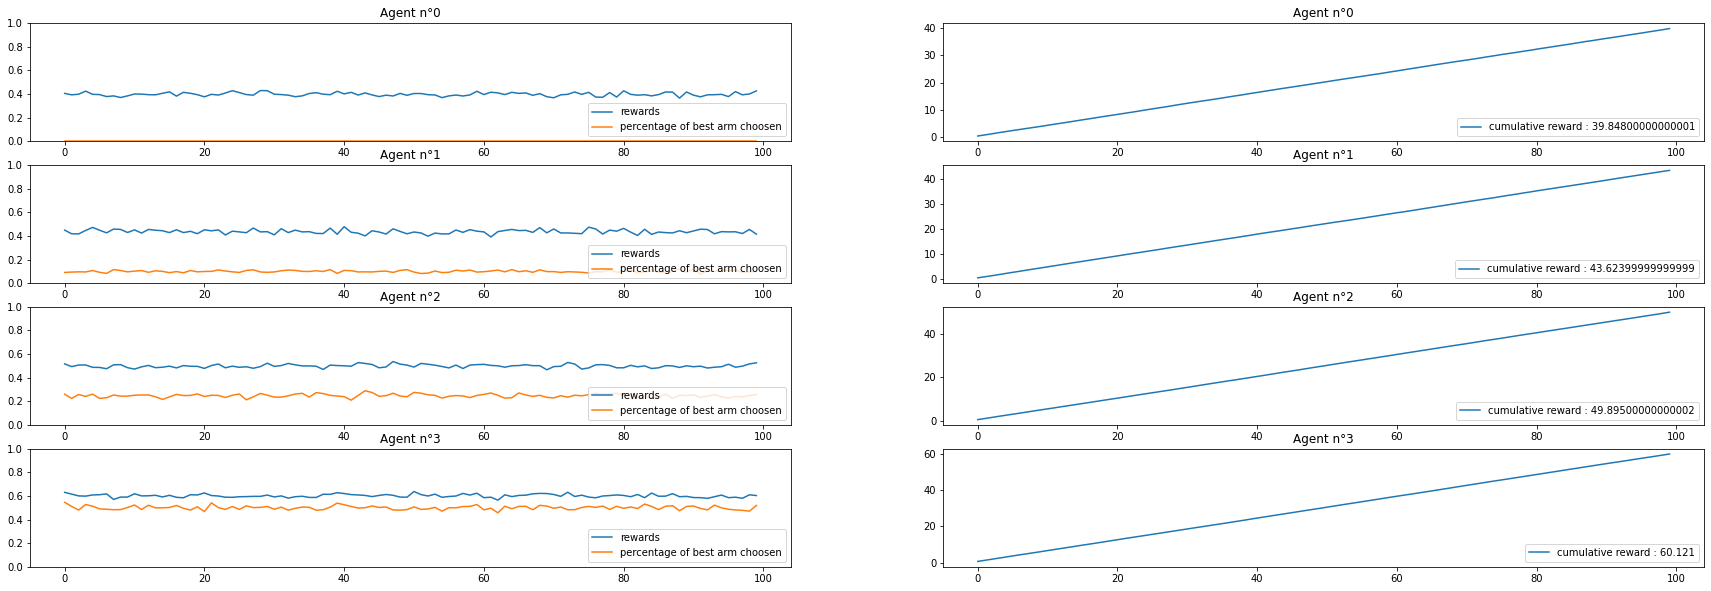

In [40]:
plot_results(agents1, res1[1], res1[0])

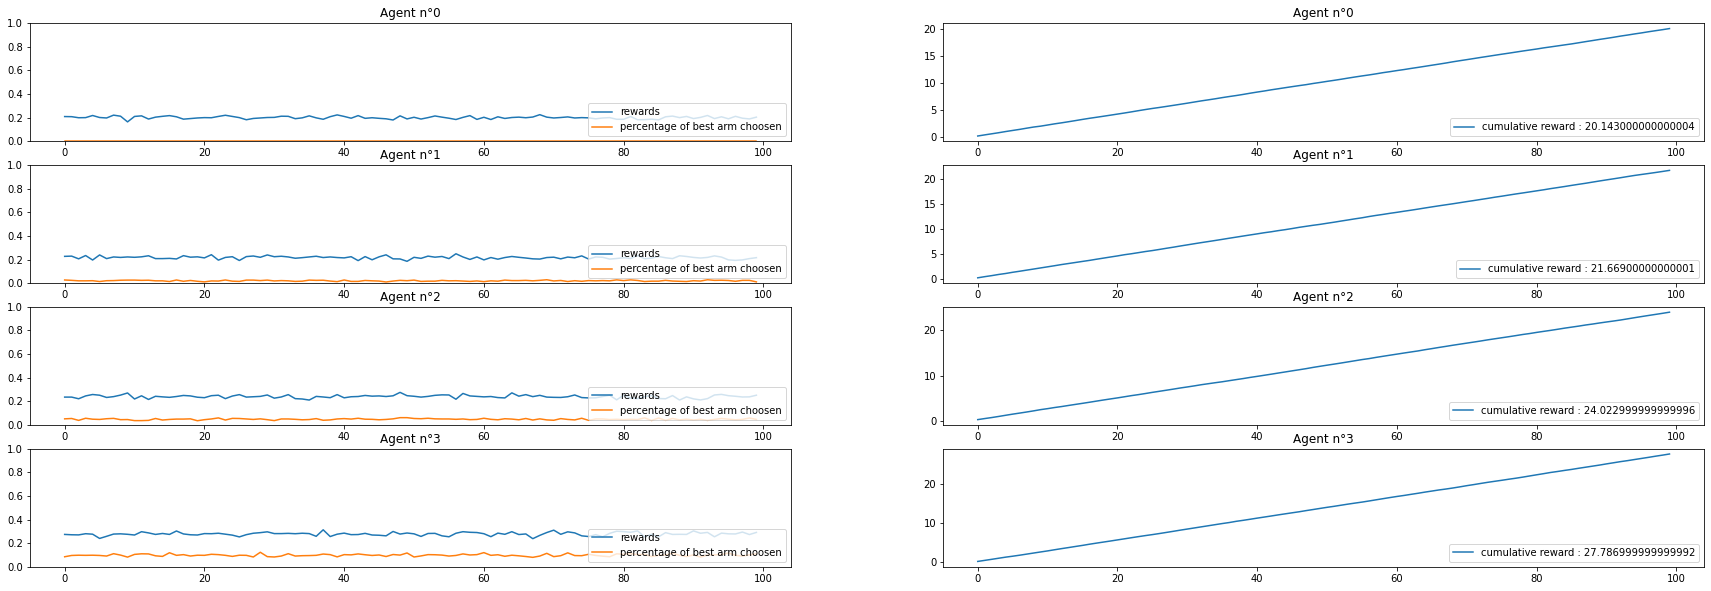

In [41]:
plot_results(agents1, res2[1], res2[0])

Interpretation : 

Here we compared greedy vs epsilon-greedy decision-rule.
It seems that the fully random methods give the best results, while the greedy get stuck in one arm and here unfortunately the worse one. 
When we increase the number of arms, this behaviour is the same. When I tried the epxerience with another initialization (in order to simulate we have an idea that the best arm could be 8th on) it seems that the greedy method manage to get stuck in the best arm, the one with the highest probability of reward.

In [47]:
param1 = {"epsilon":0.1,"UCB_param":0.1}
param2 = {"epsilon":0.1,"UCB_param":0.3}
param3 = {"epsilon":0.1,"UCB_param":0.8}
param4 = {"epsilon":0.1,"UCB_param":1} # All the choices are random

agents1 = [Agent("BayesianBetaPrior","UCB", param1), Agent("BayesianBetaPrior","UCB",param2),Agent("BayesianBetaPrior","UCB",param3), Agent("BayesianBetaPrior","UCB",param4)]
agents2 = [Agent("BayesianBetaPrior","greedy", param1), Agent("BayesianBetaPrior","epsilon-greedy",param2),Agent("BayesianBetaPrior","epsilon-greedy",param3), Agent("BayesianBetaPrior","epsilon-greedy",param4)]

res1=simulateBandits(agents1,narms=2,initp=[0.4,0.8],initq=[0.1,0.1])
res2=simulateBandits(agents1,narms=10,initp=[0.2, 0.2, 0.4, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.2],initq=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 0.1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in multiply


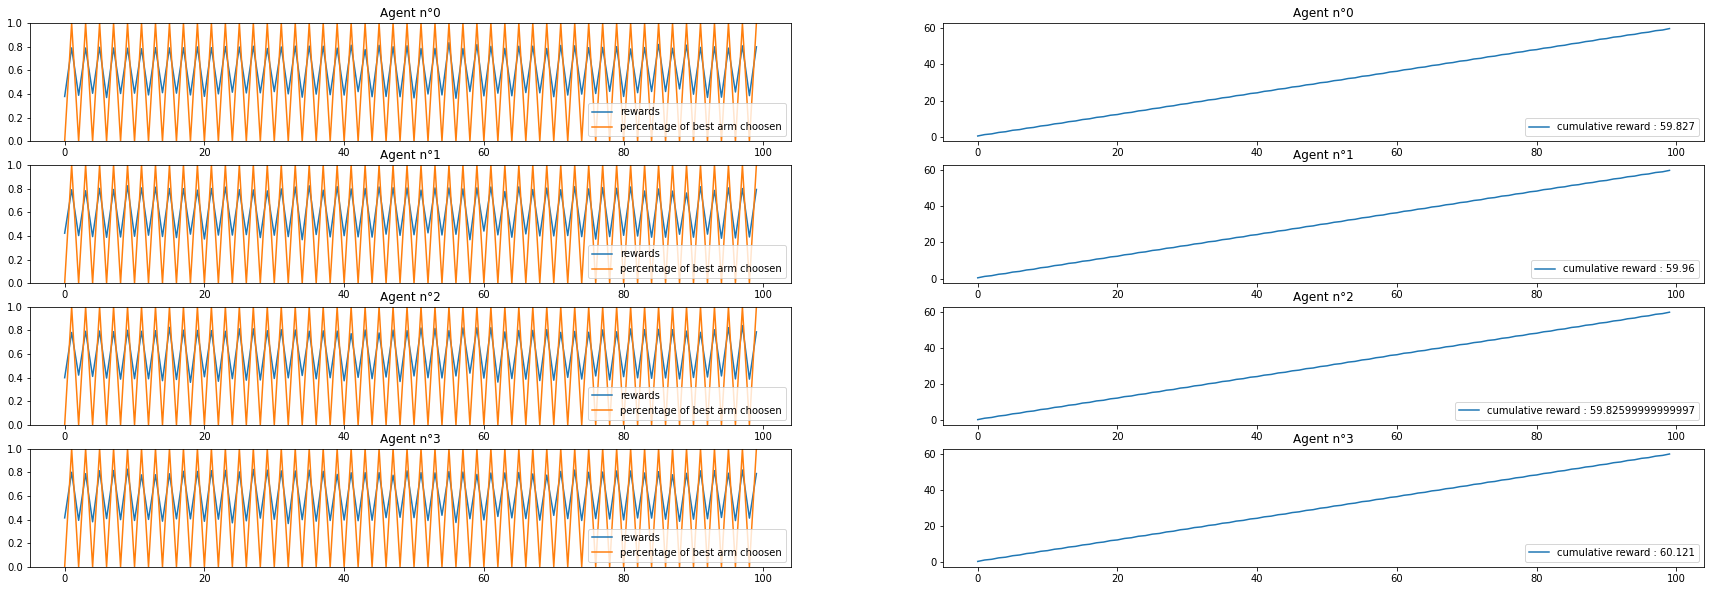

In [48]:
plot_results(agents1, res1[1], res1[0])

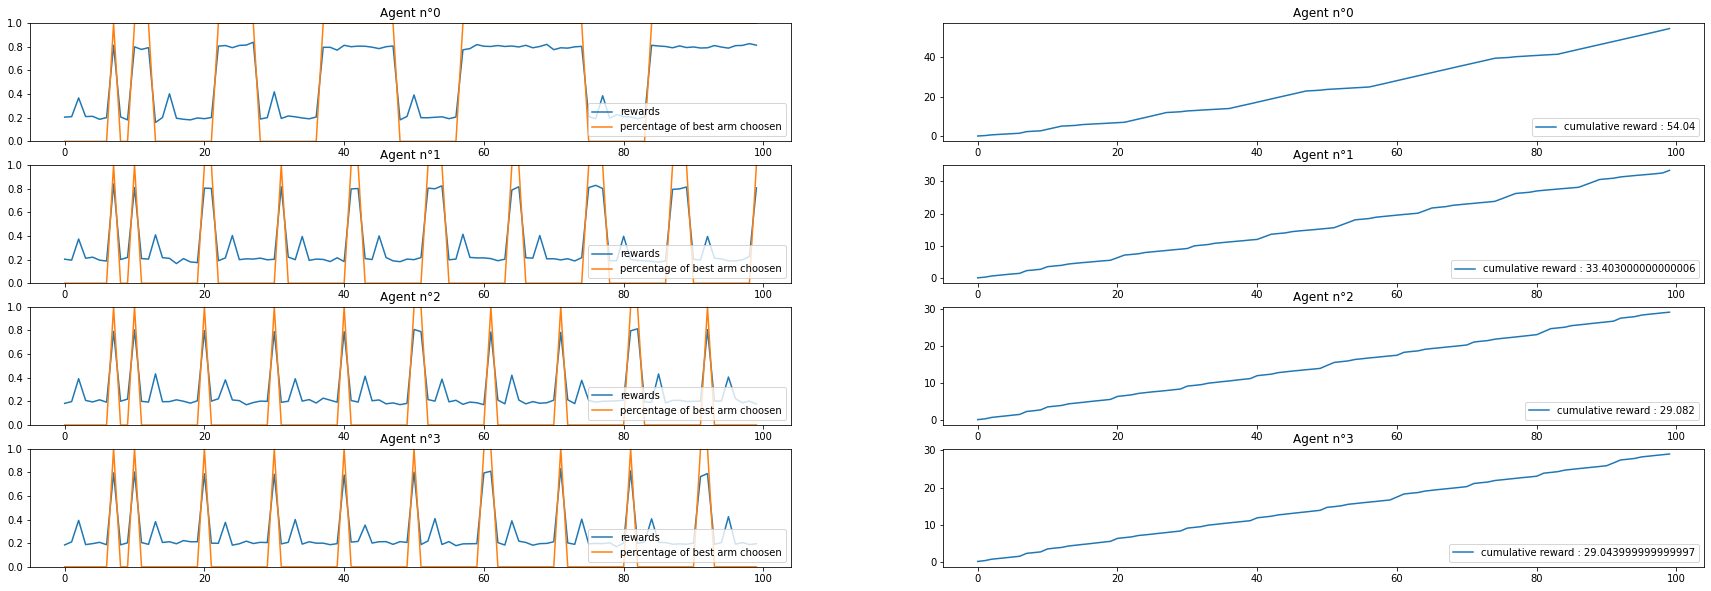

In [49]:
plot_results(agents1, res2[1], res2[0])

Interpretation :

Here we compared UCB methods with different C values (0.1 , 0.3, 0.8, 1).
When We realize the experiment with a uniform q_init (0.1 for each action), the results where extremelly close for both experiments (with both few and many arms).

For the experience with only 2 arms, the results are very similar.
For the experence with 10 arms. We can notice that the smaller the C value is, the better the results are. In fact, it seems that the process try on longer periods an arm instead of trying other arms more frequently. 

I think it would be interesting to do all those experience again but this time with nearer arms such as : [0.2, 0.2, 0.3, 0.2, 0.2, 0.2, 0.2, 0.4, 0.2, 0.2], finding the best arm (0.4) would be a more difficult task.

In [52]:
param1 = {"epsilon":0.1,"UCB_param":0.1}
param2 = {"epsilon":0.3,"UCB_param":0.3}
param3 = {"epsilon":0.5,"UCB_param":0.1}
param4 = {"epsilon":1,"UCB_param":0.1} # All the choices are random

agents1 = [Agent("BayesianBetaPrior","greedy", param1), Agent("BayesianBetaPrior","epsilon-greedy",param2),Agent("BayesianBetaPrior","UCB",param3), Agent("BayesianBetaPrior","Thompson",param4)]
#agents2 = [Agent("BayesianBetaPrior","greedy", param1), Agent("BayesianBetaPrior","epsilon-greedy",param2),Agent("BayesianBetaPrior","epsilon-greedy",param3), Agent("BayesianBetaPrior","epsilon-greedy",param4)]

#res1=simulateBandits(agents1,narms=2,initp=[0.4,0.8],initq=[0.1,0.1])
res2=simulateBandits(agents2,narms=10,initp=[0.2, 0.2, 0.3, 0.2, 0.2, 0.2, 0.2, 0.4, 0.2, 0.2],initq=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead


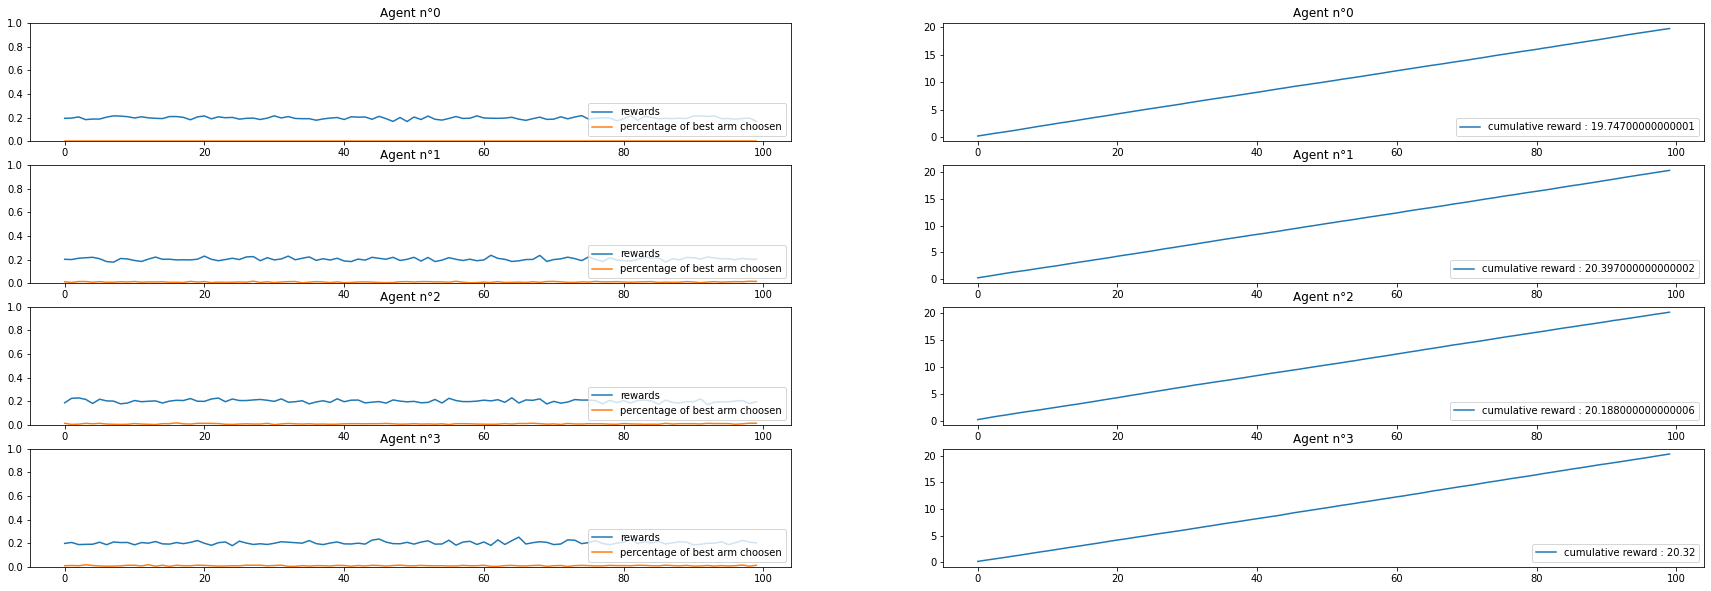

In [53]:
plot_results(agents1, res2[1], res2[0])

This time, the four decision rules have similar resuts. 